## HW 5: Darcy's Law (FEM)

In [168]:
import numpy
from matplotlib import pyplot
import pygmsh
import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve

We **attempt** to consider steady-state flow in a fully saturated porous medium.  We will assume constant porosity and viscosity for simplicity, leading to [Darcy's law](https://en.wikipedia.org/wiki/Darcy%27s_law) producing a flux
$$ q = -\kappa \nabla p $$
in terms of pressure $p$ and permeability $\kappa$.
Conservation of mass yields a Laplacian
$$ \nabla\cdot q = -\nabla\cdot \big( \kappa \nabla p \big) = 0 . $$
The velocity of the fluid is
$$ u = \frac q \phi $$
where $\phi \in (0,1]$ is porosity.

Our flow will take place on the 2D unit disc with two holes removed
$$ \left\{ x \in \mathbb R^2 : |x|<1, \big|x-(1/2,0)| > 1/4\big|, \big|x-(-1/2,0)| > 1/4\big|  \right\} . $$
The outer boundary is Neumann, corresponding to an impermeable boundary.
The left "hole" is our inejection with a relative pressure of 1 and the right is extraction with a relative pressure of 0.
We can solve for pressure as follows.

In [169]:
def fsolve_newton(F, J, u0, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    Fu = F(u)
    norm0 = numpy.linalg.norm(Fu)
    for i in range(maxit):
        du = sp.linalg.spsolve(J(u), -Fu)
        u += du
        Fu = F(u)
        norm = numpy.linalg.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'.
                  format(i+1, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

In [170]:
def tri_quad4():
    q = numpy.array([[ -0.10810301816807,   -0.78379396366386  ],
                     [ -0.78379396366386,   -0.10810301816807  ],
                     [ -0.10810301816807,   -0.10810301816807  ],
                     [-0.816847572980458,   0.633695145960917  ],
                     [ 0.633695145960917,  -0.816847572980458  ],
                     [-0.816847572980458,  -0.816847572980458  ]])
    w = numpy.array([ 0.446763179356023,
                      0.446763179356023,
                      0.446763179356023,
                      0.219903487310644,
                      0.219903487310644,
                      0.219903487310644])
    return q, w

In [171]:
#####################################
#   I DIDN'T TOUCH THESE FUNCTIONS  #
#####################################

class Mesh:
    def __init__(self, lcar=.5, shape='circle', reshape_boundary=False):
        import pygmsh
        geom = pygmsh.built_in.Geometry()
        if shape == 'circle':
            geom.add_circle((0,0,0), 1, lcar)
        elif shape == 'rectangle':
            geom.add_rectangle(-1, 1, -.5, .5, 0, lcar)
        elif shape == 'eyes':
            holes = [geom.add_circle((c,0,0), .25, .25*lcar, make_surface=False)
                 for c in (-.5, .5)]
            geom.add_circle((0,0,0), 1, lcar, holes=holes)
        else:
            raise RuntimeError('Shape not recognized:', shape)
        points, elements, _, _, _ = pygmsh.generate_mesh(geom, verbose=False, dim=2)
        vtx = points[:,:2]
        tri = elements['triangle']
        # Gmsh doesn't guarantee consistent orientation so fix up any inverted elements
        orient = numpy.cross(vtx[tri[:,1]] - vtx[tri[:,0]],
                             vtx[tri[:,2]] - vtx[tri[:,1]]) < 0
        tri[orient] = tri[orient][:,[0,2,1]]
        # Create edges
        edges = tri[:,[0,1,1,2,2,0]].reshape((-1,2))
        edges.sort(axis=1)
        ind = numpy.lexsort((edges[:,1], edges[:,0]))
        edge2vertex, starts, perm, counts = numpy.unique(edges[ind], axis=0,
                        return_index=True, return_inverse=True, return_counts=True)
        cell2edge = numpy.empty(len(edges), dtype=int)
        cell2edge[ind] = perm
        cell2edge = cell2edge.reshape((-1, 3))
        edgenumbers, edgecount = numpy.unique(cell2edge.flatten(), return_counts=True)
        edgecenter = .5*(vtx[edge2vertex[:,0]] + vtx[edge2vertex[:,1]])
        
        centroids = (vtx[tri[:,0]] + vtx[tri[:,1]] + vtx[tri[:,2]]) / 3
        h = numpy.min(numpy.linalg.norm(numpy.kron([1,1,1], centroids).reshape((-1,2))
                                        - edgecenter[cell2edge.flatten()], axis=1))
        
        # Classify boundaries
        bedges = edgenumbers[edgecount == 1]
        if shape == 'eyes':
            def distance(c, r):
                return numpy.abs(numpy.linalg.norm(edgecenter[bedges] - c, axis=1) - r)
            mouter = distance((0,0), 1)
            mleft = distance((-.5,0), .25)
            mright = distance((.5,0), .25)
            boundary = dict(outer=bedges[mouter <= numpy.minimum(mleft, mright)],
                           left=bedges[mleft <= numpy.minimum(mouter, mright)],
                           right=bedges[mright <= numpy.minimum(mleft, mouter)])
        else:
            boundary = dict(outer=bedges)
        
        self.vtx = vtx
        self.tri = tri
        self.edge2vertex = edge2vertex
        self.cell2edge = cell2edge
        self.edgecenter = edgecenter
        self.boundary = boundary
        self.shape = shape
        self.nvtx = len(vtx)
        self.nface = len(edge2vertex)
        self.h = h
        if reshape_boundary:
            self.reshape_boundary()
    
    def reshape_boundary(self):
        def project_to_circle(label, c, r):
            edges = self.boundary[label]
            x = self.edgecenter[edges]
            self.edgecenter[edges] = c + r*(x-c) / numpy.linalg.norm(x-c, axis=1)[:,None]
        if self.shape == 'circle':
            project_to_circle('outer', (0,0), 1)
        elif self.shape == 'eyes':
            project_to_circle('outer', (0,0), 1)
            project_to_circle('left', (-.5,0), .25)
            project_to_circle('right', (.5,0), .25)
            
    def tri2(self):
        _, Erestrict = self.Erestrict(2)
        return Erestrict[:,[0,3,5, 1,4,3, 2,5,4, 3,4,5]].reshape(-1,3)
    
    def Erestrict(self, p):
        if p == 1:
            return self.vtx, self.tri
        elif p == 2:
            x = numpy.vstack([self.vtx, self.edgecenter])
            Erestrict = numpy.hstack([self.tri, self.nvtx+self.cell2edge])
            return x, Erestrict
        raise RuntimeError('Not implemented for order', p)
    
    def Frestrict(self, p):
        if p == 1:
            return self.edge2vertex
        elif p == 2:
            return numpy.hstack([self.edge2vertex,
                                 self.nvtx + numpy.arange(self.nface)[:,None]])
        raise RuntimeError('Not implemented for order', p)
    
    def plotmesh(self):
        pyplot.triplot(self.vtx[:,0], self.vtx[:,1], triangles=self.tri)
        x, _ = self.Erestrict(2)
        Frestrict = self.Frestrict(2)
        for label, faces in self.boundary.items():
            xF = x[Frestrict[faces,2]]
            pyplot.plot(xF[:,0], xF[:,1], 's', label=label)
            xFv = x[Frestrict[faces,:2].flatten()]
            pyplot.plot(xFv[:,0], xFv[:,1], '.k')
        pyplot.legend()

In [172]:
#####################################
#   I DIDN'T TOUCH THESE FUNCTIONS  #
#####################################

class fe2tri:
    def __init__(self, p):
        x1 = numpy.array([[-1, 1], [-1, -1], [1, -1]])
        x2 = numpy.array([[-1, 0], [0, -1], [0, 0]])
        if p == 1:
            x = x1
        elif p == 2:
            x = numpy.vstack([x1, x2])
        self.p = p
        self.xref = x
        self.q, self.w = tri_quad4() # Could use fewer points for p==1
        V, _ = self.prime(x)
        Vinv = numpy.linalg.inv(V)
        Bprime, Dprime = self.prime(q)
        self.B = Bprime @ Vinv
        self.D = Dprime @ Vinv

    def prime(self, x):
        V = numpy.ones((len(x), len(self.xref)))
        dV = numpy.zeros((len(x), 2, len(self.xref)))
        V[:,1] = x[:,0]
        V[:,2] = x[:,1]
        # dV[:,2*i] is derivative in x direction, dV[:,2*i+1] is in y-direction
        dV[:,0,1] = 1
        dV[:,1,2] = 1
        if self.p > 1:
            V[:,3] = x[:,0]**2
            V[:,4] = x[:,0]*x[:,1]
            V[:,5] = x[:,1]**2
            dV[:,0,3] = 2*x[:,0]
            dV[:,0,4] = x[:,1]
            dV[:,1,4] = x[:,0]
            dV[:,1,5] = 2*x[:,1]
        return V, dV
    
    def meshref(self):
        # Mesh for plotting on reference element
        x1 = numpy.linspace(-1, 1)
        xx, yy = numpy.meshgrid(x1, x1)
        for i,y in enumerate(yy):
            xx[i] = numpy.linspace(-1, -y[0])
        return numpy.vstack([xx.flatten(), yy.flatten()]).T
    
    def plot(self):
        pyplot.plot(self.xref[:,0], self.xref[:,1], 'o')
        pyplot.plot(self.q[:,0], self.q[:,1], 's')
        pyplot.triplot([-1, -1, 1], [1, -1, -1])
        
        X = self.meshref()
        Vinv = numpy.linalg.inv(self.prime(self.xref)[0])
        Bprime = self.prime(X)[0]
        B = Bprime @ Vinv
        pyplot.figure()
        for i in range(6):
            from matplotlib import cm
            pyplot.subplot(2, 3, i+1)
            pyplot.tricontourf(X[:,0], X[:,1], B[:,i], 30, cmap=cm.seismic, vmin=-1, vmax=1)

In [173]:
class laplacian2:
    def __init__(self, k=1,  exact='1'):
        self.k = k
        self.exact = getattr(self, 'exact_' + exact)
        self.forcing = getattr(self, 'forcing_' + exact)
        
    def form(self, x, u, Du):
        return (self.forcing(x), self.k*Du), ((0, 0), (0, self.k*numpy.eye(2)[None,:,:]))
    def exact_1(self, x):
        return x[:,0] + x[:,1]
    def forcing_1(self, x):
        return 0
    def exact_2(self, x):
        return x[:,0]*x[:,1] + 2*x[:,0]**2 - x[:,1]**2 + x[:,1]
    def forcing_2(self, x):
        return 2
    def exact_warp(self, xx):
        from numpy import tanh, exp
        k, x, y = self.k, xx[:,0], xx[:,1]
        return tanh(k*x) * exp(-4*y**2)
    def forcing_warp(self, xx):
        from numpy import tanh, exp
        k, x, y = self.k, xx[:,0], xx[:,1]
        return 2*k**2*(tanh(k*x)**2 - 1)*exp(-4*y**2)*tanh(k*x) + 8*(8*y**2 - 1)*exp(-4*y**2)*tanh(k*x)


Since $q= -\kappa \nabla p$, $u= \frac{-\kappa \nabla p}{\phi}$

In [174]:
class laplace2Temperature:
    def __init__(self, phi=0.5, k=1,  exact='1'):
        self.k = k
        self.exact = getattr(self, 'exact_' + exact)
        self.forcing = getattr(self, 'forcing_' + exact)
        self.phi= phi
        
    def form(self, x, u, Du, finalD):
        return (self.forcing(x), self.k*Du+self.k/self.phi*finalD*(numpy.tile(u,(2,1))).T), ((0, 0), (self.k/self.phi*finalD,numpy.eye(2)[None,:,:]))
    def exact_1(self, x):
        return x[:,0] + x[:,1]
    def forcing_1(self, x):
        return 0
    def exact_2(self, x):
        return x[:,0]*x[:,1] + 2*x[:,0]**2 - x[:,1]**2 + x[:,1]
    def forcing_2(self, x):
        return 2
    def exact_warp(self, xx):
        from numpy import tanh, exp
        k, x, y = self.k, xx[:,0], xx[:,1]
        return tanh(k*x) * exp(-4*y**2)
    def forcing_warp(self, xx):
        from numpy import tanh, exp
        k, x, y = self.k, xx[:,0], xx[:,1]
        return 2*k**2*(tanh(k*x)**2 - 1)*exp(-4*y**2)*tanh(k*x) + 8*(8*y**2 - 1)*exp(-4*y**2)*tanh(k*x)


In [175]:
def fe2_solveTemp(fe, mesh, form, formTemp, dirichlet={}, spy=False):
    x, Erestrict = mesh.Erestrict(fe.p)
    Frestrict = mesh.Frestrict(fe.p)
    Ndof = len(x)
    B, D = fe.B, fe.D
    xq, W, dXdx = fe2_geom(fe, mesh)
    dirichletidx = []
    bcmask = numpy.zeros(Ndof, dtype=bool)
    for label, func in dirichlet.items():
        indices = Frestrict[mesh.boundary[label]].flatten()
        dirichletidx.append((label, indices, func))
        bcmask[indices] = True
    
    def project_dirichlet(u): # Affine projector into space satisfying Dirichlet BC
        ubc = u.copy()
        for label, indices, func in dirichletidx:
            ubc[indices] = func(x[indices])
        return ubc

    def residual(u):
        ubc = project_dirichlet(u)
        v = u - ubc
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            uq = B @ uE
            Dxuq = numpy.einsum('ixX,iX->ix', dXdx[e], D @ uE)
            f, _ = form(xq[e], uq, Dxuq)
            
            vE = B.T @ (W[e] * f[0]) + numpy.einsum('iXp,ixX,ix->p',
                                                    D, dXdx[e], W[e,:,None] * f[1])
            vE[bcmask[E]] = 0
            v[E] += vE
        return v 

    def jacobian(u):
        ubc = project_dirichlet(u)
        ai = []
        aj = []
        aa = []
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            Dx = numpy.einsum('ixX,iXp->ixp', dXdx[e], D)
            _, df = form(xq[e], B @ uE, Dx @ uE)
            Ae = (numpy.einsum('qi,q,qj->ij', B, W[e] * df[0][0], B)
                  + numpy.einsum('qi,qy,qyj->ij', B, W[e,:,None] * df[0][1], Dx)
                  + numpy.einsum('qxi,qx,qj->ij', Dx, W[e,:,None] * df[1][0], B)
                  + numpy.einsum('qxi,qxy,qyj->ij', Dx, W[e,:,None,None] * df[1][1], Dx))
            Ae[bcmask[E],:] = 0
            Ae[:,bcmask[E]] = 0
            ai += numpy.outer(E, numpy.ones_like(E)).flatten().tolist()
            aj += numpy.outer(numpy.ones_like(E), E).flatten().tolist()
            aa += Ae.flatten().tolist()
        bcidx = numpy.where(bcmask)[0].tolist()
        ai += bcidx
        aj += bcidx
        aa += numpy.ones_like(bcidx).tolist()
        A = sp.csr_matrix((aa, (ai, aj)), shape=(Ndof,Ndof))
        if spy:
            pyplot.spy(A)
        return A
    #print("Solving for p")
    u0 = numpy.zeros(Ndof) # initial guess
    u, nit = fsolve_newton(residual, jacobian, u0, verbose=False)
    
    ubc = project_dirichlet(u)
    #To get the gradient of p:
    for e, E in enumerate(Erestrict):
        uE = ubc[E]
        uq = B @ uE
        gradP = numpy.einsum('ixX,iX->ix', dXdx[e], D @ uE)
    
    def residualTemp(temp):
        ubc = project_dirichlet(temp)
        v = temp - ubc
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            uqT = B @ uE
            DTuq = numpy.einsum('ixX,iX->ix', dXdx[e], D @ uE)
            f, _ = formTemp(xq[e], uqT, DTuq, gradP)
            
            vE = B.T @ (W[e] * f[0]) + numpy.einsum('iXp,ixX,ix->p',
                                                    D, dXdx[e], W[e,:,None] * f[1])
            vE[bcmask[E]] = 0
            v[E] += vE
        return v 

    def jacobianTemp(temp):
        ubc = project_dirichlet(temp)
        ai = []
        aj = []
        aa = []
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            Dx = numpy.einsum('ixX,iXp->ixp', dXdx[e], D)
            _, df = formTemp(xq[e], B @ uE, Dx @ uE, gradP)
            Ae = (numpy.einsum('qi,q,qj->ij', B, W[e] * df[0][0], B)
                  + numpy.einsum('qi,qy,qyj->ij', B, W[e,:,None] * df[0][1], Dx)
                  + numpy.einsum('qxi,qx,qj->ij', Dx, W[e,:,None] * df[1][0], B)
                  + numpy.einsum('qxi,qxy,qyj->ij', Dx, W[e,:,None,None] * df[1][1], Dx))
            Ae[bcmask[E],:] = 0
            Ae[:,bcmask[E]] = 0
            ai += numpy.outer(E, numpy.ones_like(E)).flatten().tolist()
            aj += numpy.outer(numpy.ones_like(E), E).flatten().tolist()
            aa += Ae.flatten().tolist()
        bcidx = numpy.where(bcmask)[0].tolist()
        ai += bcidx
        aj += bcidx
        aa += numpy.ones_like(bcidx).tolist()
        A = sp.csr_matrix((aa, (ai, aj)), shape=(Ndof,Ndof))
        if spy:
            pyplot.spy(A)
        return A
    #print("Solving for Temperature")
    
    # Solved for u and returned x, now I need to solve for
    # temperature
    temp0= numpy.zeros(Ndof)
    u0 = numpy.zeros(Ndof) # initial guess
    temp, nit = fsolve_newton(residualTemp, jacobianTemp, temp0, verbose=False)
    return x, u, temp, gradP

def fe2_geom(fe, mesh):
    x, Erestrict = mesh.Erestrict(fe.p)
    nelem = len(Erestrict)
    Q = len(fe.w)
    B, D = fe.B, fe.D
    W = numpy.empty((nelem, Q))
    dXdx = numpy.empty((nelem, Q, 2, 2))
    xq = numpy.empty((nelem, Q, 2))
    for e, E in enumerate(Erestrict):
        xE = x[E,:]
        xq[e] = B @ xE
        dxdX = D @ xE # 2x2 matrices at each quadrature point
        det = numpy.linalg.det(dxdX)
        W[e] = w * det # Quadrature weight on physical element
        dXdx[e] = numpy.linalg.inv(dxdX)
    return xq, W, dXdx

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


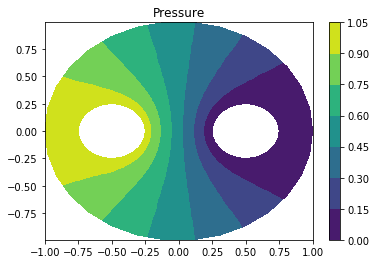

In [178]:
q, w = tri_quad4()
mesh = Mesh(shape='eyes',reshape_boundary=True)
fe = fe2tri(2)
prob= laplacian2()
probTemp= laplace2Temperature()
x, pressure, temperature, gradP = fe2_solveTemp(fe, mesh, prob.form,probTemp.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
pyplot.tricontourf(x[:,0], x[:,1], pressure, triangles=mesh.tri2())
pyplot.title('Pressure')
pyplot.colorbar();
pyplot.show()

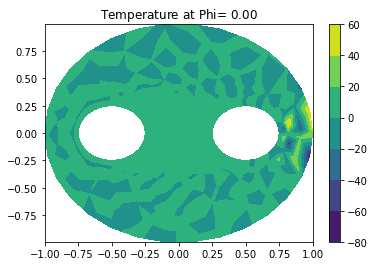

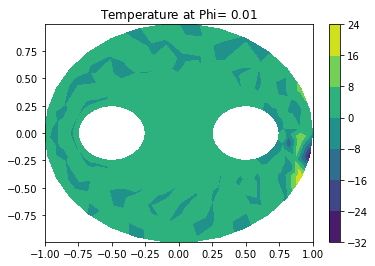

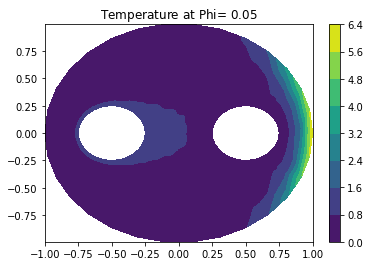

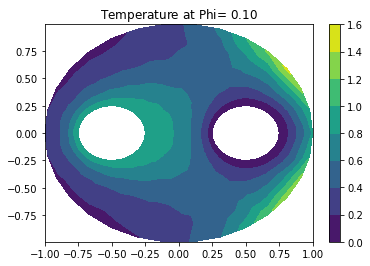

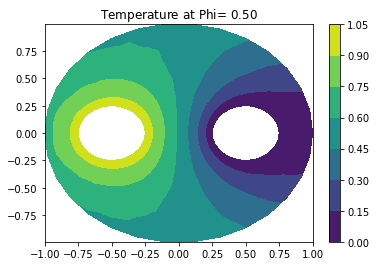

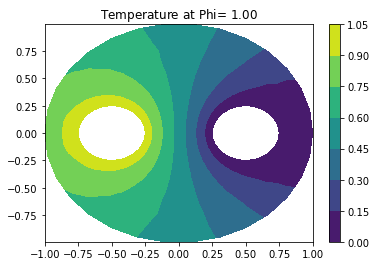

In [179]:
for phi1 in [3e-3,5e-3, 5e-2, 0.1,5e-1, 1]:
    probTemp.phi= phi1

    x, pressure, temperature, velocity = fe2_solveTemp(fe, mesh, prob.form, probTemp.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature at Phi= $%.2f$' %phi1)
    pyplot.colorbar();
    pyplot.show()

The Newton Solver solved each one of these cases in one iteration, but I used verbose=False because in the further answers I will be solving multiple times, want to use the same functions and it would clutter the whole thing.

**With respect to your numerically computed solutions, think about the following questions.**

**1. What is the order of accuracy of $p$, $u$, and $T$ for linear `fe2tri(1)` and quadratic `fe2tri(2)` elements? Rather than interpolating to compare in a norm, you can compare by computing moments of the error, such as
$$ \int_\Omega x (u_{2h} - u_h)(x,y) = \int_\Omega x u_{2h}(x,y) - \int_\Omega x u_h(x,y), $$
where the two integrals on the right can be carried out on the natural quadrature of each mesh independently.**


In [182]:
#Getting both solutions for fe2 and fe1
q, w = tri_quad4()
mesh = Mesh(shape='eyes', lcar=0.4, reshape_boundary=True)
fe2 = fe2tri(2)
fe1 = fe2tri(1)

prob= laplacian2()
probTemp= laplace2Temperature()
x, pressure, temperature, velocity = fe2_solveTemp(fe2, mesh, prob.form, probTemp.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
x1, pressure1, temperature1, velocity1 = fe2_solveTemp(fe1, mesh, prob.form, probTemp.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


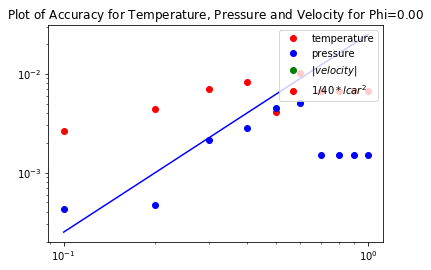

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


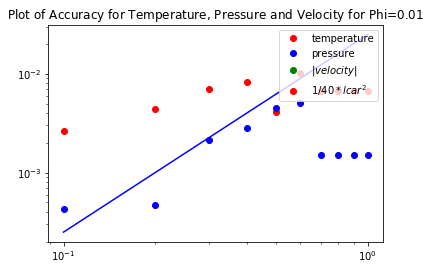

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


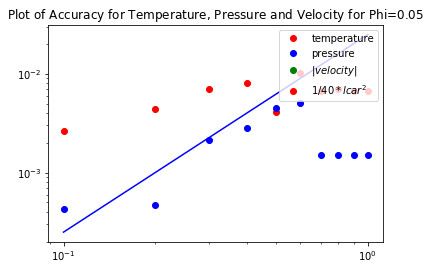

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


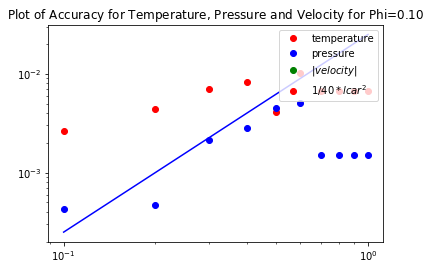

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


In [ ]:
# Carrying the integrals for the moments in a natural quadrature:

def quad_trapezoid(n):
    q = numpy.linspace(-1, 1, n)
    w = 0*q + 2/(n-1)
    w[[0,-1]] /= 2
    return q, w



#sols = []
for phi1 in [3e-3,5e-3, 5e-2, 0.1,5e-1, 1]:
    probTemp.phi= phi1
    lcars = numpy.zeros(11)
    i=0
    for lcar in numpy.linspace(0.1, 1, 10):
        i+=1
        q, w = tri_quad4()
        mesh = Mesh(shape='eyes',lcar=lcar, reshape_boundary=True)
        fe2 = fe2tri(2)
        fe1 = fe2tri(1)

        prob= laplacian2()
        probTemp= laplace2Temperature()
        _, pressure, temperature, velocity = fe2_solveTemp(fe2, mesh, prob.form, probTemp.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
        _, pressure1, temperature1, velocity1 = fe2_solveTemp(fe1, mesh, prob.form, probTemp.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    
        q, w= quad_trapezoid(len(temperature))
        q1, w1= quad_trapezoid(len(temperature1))
        Acc1temp= w.dot(temperature)
        Acc2temp= w1.dot(temperature1)
    
        q, w= quad_trapezoid(len(pressure))
        q1, w1= quad_trapezoid(len(pressure1))
        Acc1pres= w.dot(pressure)
        Acc2pres= w1.dot(pressure1)
    
        q, w= quad_trapezoid(len(velocity))
        q1, w1= quad_trapezoid(len(velocity1))
        Acc1vel= w.dot(velocity)
        Acc2vel= w1.dot(velocity1)
    
        pyplot.loglog(lcar, -Acc2temp+Acc1temp, 'or')
        pyplot.loglog(lcar, -Acc2pres+ Acc1pres, 'ob')
        pyplot.loglog(lcar, numpy.linalg.norm(Acc2vel- Acc2vel, numpy. inf), 'og')

        #sols.append([-Acc2temp+Acc1temp,-Acc2pres+ Acc1pres, numpy.linalg.norm(Acc2vel- Acc2vel, numpy.inf), 1./(lcar)**2])
        lcars[i]= lcar
    
    pyplot.loglog(lcars, 1/40*lcars**2, 'b')

    label= ("temperature", "pressure", "$\|velocity\|$", "$ 1/40* lcar^2$")
    pyplot.title("Plot of Accuracy for Temperature, Pressure and Velocity for Phi=$%.2f$"%phi1)
    pyplot.legend(label,loc= 'upper right')
    pyplot.show()

What I interpreted from this plot is that the pressure and the norm of the velocity hold the same dependence on the grid size.

**2. When porosity $\phi$ decreases (at fixed permeability), the velocity increases.  Can you obtain an accurate solution for $T$ for any value of $\phi$ or is there a relationship between $\phi$ and the grid size $h$?**

As seen in the previous example, the solution for a given value of $\phi$ behaves with the same accuracy in those plots. Therefore, I would say that the solutions for $\phi$ are independent of the grid size in the sense that no matter what values $\phi$ has, you are going to get as good of an accuracy as your grid size is able to provide.